In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import json
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/hominterp1de/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
#import ants
import bigbadbrain as bbb
from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

### Load Data: bleaching.npy and scan.json

In [2]:
bleaching_data = {}
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
fly_folders = [os.path.join(root_directory,x) for x in os.listdir(root_directory) if 'fly' in x]
bbb.sort_nicely(fly_folders)
fly_folders = fly_folders[::-1]
#fly_folders = [os.path.join(root_directory, 'fly_52')]
metadata = {}

for fly in fly_folders:
    expt_folders = []
    expt_folders = [os.path.join(fly,x) for x in os.listdir(fly) if 'func' in x]
    if len(expt_folders) > 0:
        for expt_folder in expt_folders:
            try:
                fly_num = os.path.split(fly)[-1]
                expt_num = os.path.split(expt_folder)[-1]
                this_expt = '{},{}'.format(fly_num, expt_num)
                bleaching_file = os.path.join(expt_folder, 'imaging', 'bleaching_analysis.npy')
                bleaching_data_temp = np.load(bleaching_file).tolist()
                bleaching_data[this_expt] = bleaching_data_temp
                print('SUCCESS: {}'.format(this_expt))

                scan_file = os.path.join(expt_folder, 'imaging', 'scan.json')
                #print(scan_file)
                with open(scan_file, 'r+') as f:
                    metadata[this_expt] = json.load(f)
                    
            except:
                print('FAIL: {}'.format(this_expt))

SUCCESS: fly_69,func_0
SUCCESS: fly_68,func_0
SUCCESS: fly_54,func_0
SUCCESS: fly_53,func_0
SUCCESS: fly_52,func_0
SUCCESS: fly_51,func_0
SUCCESS: fly_49,func_0
SUCCESS: fly_48,func_0
SUCCESS: fly_47,func_0
SUCCESS: fly_46,func_0
SUCCESS: fly_46,func_1
SUCCESS: fly_45,func_0
SUCCESS: fly_44,func_0
SUCCESS: fly_43,func_0
SUCCESS: fly_43,func_1
SUCCESS: fly_43,func_2
SUCCESS: fly_42,func_0
SUCCESS: fly_42,func_1
SUCCESS: fly_41,func_0
SUCCESS: fly_40,func_0
SUCCESS: fly_39,func_0
SUCCESS: fly_39,func_1
SUCCESS: fly_38,func_0
SUCCESS: fly_38,func_1
SUCCESS: fly_37,func_0
SUCCESS: fly_37,func_1
SUCCESS: fly_37,func_2
SUCCESS: fly_36,func_0
SUCCESS: fly_36,func_1
SUCCESS: fly_36,func_2
SUCCESS: fly_35,func_0
SUCCESS: fly_35,func_1
SUCCESS: fly_35,func_2
SUCCESS: fly_34,func_0
SUCCESS: fly_34,func_1
SUCCESS: fly_33,func_0
SUCCESS: fly_33,func_1
FAIL: fly_31,func_0
SUCCESS: fly_30,func_0
FAIL: fly_30,func_1
SUCCESS: fly_29,func_0
SUCCESS: fly_29,func_1
SUCCESS: fly_28,func_0
SUCCESS: fly_27,f

### Class for scale bars

In [3]:
from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, xsep=2, ysep=2, prop=None, barcolor="black", barwidth=None, mirror=False, 
                 **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        
        #y_pix_unit = (transform.transform([(0,1),(1,0)])-transform.transform((0,0)))[0][1]
        #x_pix_unit = (transform.transform([(0,1),(1,0)])-transform.transform((0,0)))[1][0]
        
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, ec=barcolor, lw=barwidth, fc="none"))
        if sizey:
            if mirror:
                bars.add_artist(Rectangle((sizex,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))
            else:
                bars.add_artist(Rectangle((0,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))

        if sizex and labelx:
            self.xlabel = TextArea(labelx, minimumdescent=False)
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=xsep)
        if sizey and labely:
            self.ylabel = TextArea(labely)
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=ysep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

        
def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)
    if hidex and hidey: ax.set_frame_on(False)

    return sb

In [148]:
for i,expt in enumerate(bleaching_data):
    try:
        print('{}, {}'.format(expt, len(bleaching_data[expt]['bleaching'])))
    except:
        pass

fly_69,func_0, 4234
fly_68,func_0, 4234
fly_54,func_0, 4694
fly_53,func_0, 4694
fly_52,func_0, 5130
fly_51,func_0, 4620
fly_49,func_0, 4977
fly_48,func_0, 4566
fly_47,func_0, 4817
fly_46,func_0, 5100
fly_46,func_1, 5100
fly_45,func_0, 4476
fly_44,func_0, 5261
fly_43,func_0, 5230
fly_43,func_1, 5230
fly_43,func_2, 5230
fly_42,func_0, 4872
fly_42,func_1, 4872
fly_41,func_0, 6450
fly_40,func_0, 6161
fly_39,func_0, 7538
fly_39,func_1, 8379
fly_38,func_0, 3398
fly_38,func_1, 6303
fly_37,func_0, 6189
fly_37,func_1, 6983
fly_37,func_2, 9108
fly_36,func_0, 7759
fly_36,func_1, 7759
fly_36,func_2, 13965
fly_35,func_0, 5248
fly_35,func_1, 7421
fly_35,func_2, 9108
fly_34,func_0, 10320
fly_34,func_1, 10474
fly_30,func_0, 5113
fly_29,func_0, 5230
fly_29,func_1, 6450
fly_28,func_0, 4493
fly_27,func_0, 4833
fly_26,func_0, 4332
fly_25,func_0, 4128
fly_24,func_0, 4359
fly_23,func_0, 4755
fly_22,func_0, 4238
fly_21,func_0, 4370
fly_20,func_0, 3384
fly_19,func_0, 4554
fly_18,func_0, 3924
fly_17,func_0, 39

In [37]:
for i,expt in enumerate(bleaching_data):
    try:
        #if len(bleaching_data[expt]['bleaching']) >
        fly_num = int(expt.split('_')[1].split(',')[0])
        if fly_num in good_flies:
            print('{}, {}'.format(expt, len(bleaching_data[expt]['bleaching'])))
    except:
        pass

fly_54,func_0, 4694
fly_53,func_0, 4694
fly_52,func_0, 5130
fly_51,func_0, 4620
fly_49,func_0, 4977
fly_48,func_0, 4566
fly_47,func_0, 4817
fly_46,func_0, 5100
fly_46,func_1, 5100
fly_45,func_0, 4476
fly_44,func_0, 5261
fly_43,func_0, 5230
fly_43,func_1, 5230
fly_43,func_2, 5230
fly_26,func_0, 4332
fly_25,func_0, 4128
fly_24,func_0, 4359
fly_23,func_0, 4755
fly_22,func_0, 4238
fly_21,func_0, 4370
fly_19,func_0, 4554
fly_17,func_0, 3924
fly_15,func_0, 4891
fly_14,func_0, 4076
fly_13,func_0, 5058
fly_12,func_0, 4797
fly_11,func_0, 4411
fly_10,func_0, 4119
fly_9,func_0, 4238
fly_8,func_0, 4159
fly_7,func_0, 4006
fly_6,func_0, 5805
fly_5,func_0, 4731
fly_4,func_0, 5317
fly_3,func_0, 3932
fly_2,func_0, 4569
fly_1,func_0, 4006


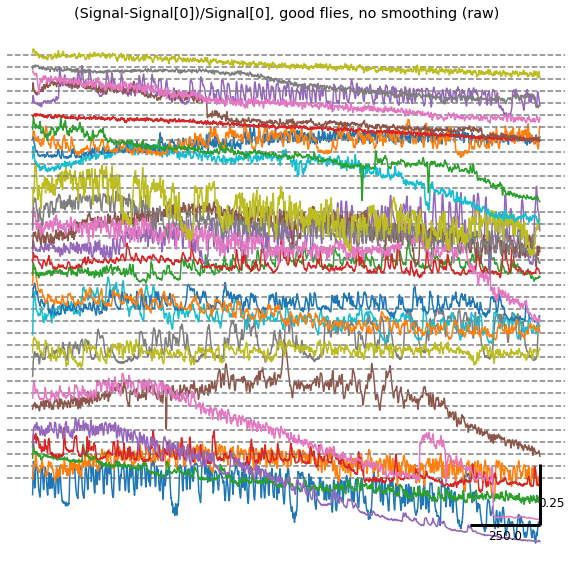

In [15]:
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 12})


weird_flies = [6,23,69]
#weird_flies= []
good_flies = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,21,22,23,24,25,26,31,43,44,45,46,47,48,49,51,52,53,54,68,69]
step = .05
bubble_thresh = 3
j=0
good_expts = {}
bubble_values = []
starting_fluors = {}
ending_fluors = {}
signal_decrease = {}
bleaching_decay = {}
snr = {}
color = np.divide((170,35,255),255)
for i,expt in enumerate(bleaching_data):
    j+=1
    try:
        #if len(bleaching_data[expt]['bleaching']) >
        fly_num = int(expt.split('_')[1].split(',')[0])
        if fly_num in good_flies and fly_num not in weird_flies:
        #if fly_num in good_flies:
            smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['bleaching'],sigma=4,axis=-1,truncate=1)
            super_smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['bleaching'],sigma=100,axis=-1,truncate=1)
            super_smoothed_diff = np.diff(super_smoothed[::100])
            bubble_value = np.min(super_smoothed_diff)*-1
            bubble = False
            bubble_values.append(bubble_value)
            if bubble_value > bubble_thresh:
                bubble = True
                #bubble = False
                #continue
                #to_print = expt + '*'
            else:
                #to_print = expt
                pass
                

            
            num_frames = len(bleaching_data[expt]['bleaching'])
            imaging_rate = 1800/num_frames
            xs = np.arange(0,1800,imaging_rate)
            starting_fluor = np.mean(smoothed[:100])
            normalized_signal = (smoothed-starting_fluor)/starting_fluor
            
            
            ending_fluor = np.mean(smoothed[-100:])
            
            
            # Fit slope
            linear_fit = np.polyfit(xs, normalized_signal, 1)
            
            ax.axhline(step*j,color='grey',linestyle='--')
            
            #if fly_num in weird_flies:
            #    ax.plot(xs, normalized_signal+step*j,color='r')
            #else:
            #    ax.plot(xs, normalized_signal+step*j,color='k')
            
            # plot as red line if bubble
            if bubble:
                continue
                #ax.plot(xs, normalized_signal+step*j,color='r')
            
            ax.plot(xs, normalized_signal+step*j)
            #ax.plot(xs, np.poly1d(linear_fit)(xs)+step*j,color='r',linestyle='--')
            
            
            signal_lost = np.poly1d(linear_fit)(1800)-np.poly1d(linear_fit)(0)
            percent_signal_lost = signal_lost*-100
            bleaching_decay[expt] = percent_signal_lost
            
            mean_signal = np.mean(bleaching_data[expt]['bleaching'])
            sd = np.std(bleaching_data[expt]['bleaching'])
            snr[expt] = sd
            
            
            #ax.text(-120,step*j,'{:.0f}%'.format(percent_signal_lost))
            good_expts[expt] = linear_fit[1]
            starting_fluors[expt] = starting_fluor
            ending_fluors[expt] = ending_fluor
            signal_decrease[expt] = linear_fit[1] * num_frames
            #plt.text(-50,1+step*i,'{:0.0f}'.format(bleaching_data[expt]['percent_signal_lost']))
            #print(len((bleaching_data[expt]['percent_above_thresh'])))
        else:
            j-=1
            #plt.text(-240,1+step*i,'exclude')
    except:
        continue
ax.axis('off')
plt.title('(Signal-Signal[0])/Signal[0], good flies, no smoothing (raw)')
add_scalebar(ax, barwidth=3, mirror=True,ysep=-95,xsep=5,pad=2);

Text(0.5, 0, 'Time, min')

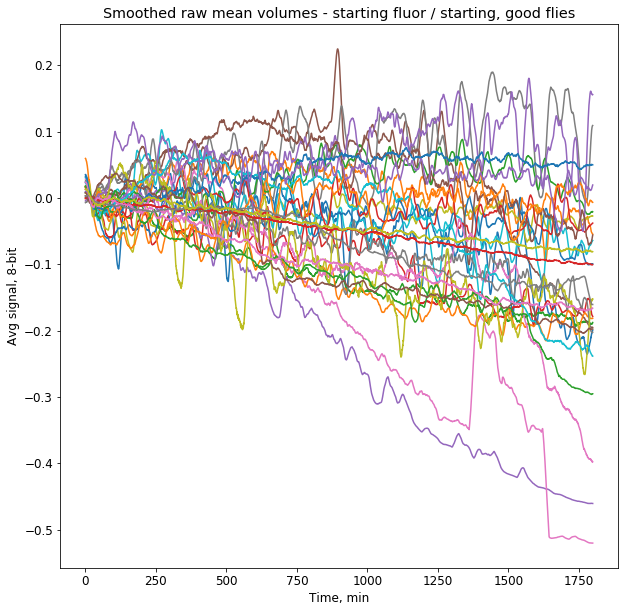

In [26]:
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 12})


weird_flies = [6,23,69]
#weird_flies= []
good_flies = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,21,22,23,24,25,26,31,43,44,45,46,47,48,49,51,52,53,54,68,69]
step = .05
bubble_thresh = 3
j=0
good_expts = {}
bubble_values = []
starting_fluors = {}
ending_fluors = {}
signal_decrease = {}
bleaching_decay = {}
snr = {}
color = np.divide((170,35,255),255)
for i,expt in enumerate(bleaching_data):
    j+=1
    try:
        fly_num = int(expt.split('_')[1].split(',')[0])
        if fly_num in good_flies and fly_num not in weird_flies:
            smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['bleaching'],sigma=30,axis=-1,truncate=1)
            super_smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['bleaching'],sigma=100,axis=-1,truncate=1)
            super_smoothed_diff = np.diff(super_smoothed[::100])
            bubble_value = np.min(super_smoothed_diff)*-1
            bubble = False
            bubble_values.append(bubble_value)
            if bubble_value > bubble_thresh:
                bubble = True
            else:
                pass

            num_frames = len(bleaching_data[expt]['bleaching'])
            imaging_rate = 1800/num_frames
            xs = np.arange(0,1800,imaging_rate)
            starting_fluor = np.mean(smoothed[:100])
            #normalized_signal = (smoothed-starting_fluor)/starting_fluor
            normalized_signal = (smoothed-starting_fluor)/starting_fluor
            
            ending_fluor = np.mean(smoothed[-100:])
            
            
            # Fit slope
            linear_fit = np.polyfit(xs, normalized_signal, 1)
            
            #ax.axhline(step*j,color='grey',linestyle='--')

            
            # plot as red line if bubble
            if bubble:
                continue
                #ax.plot(xs, normalized_signal+step*j,color='r')
            
            ax.plot(xs, normalized_signal)
            #ax.plot(xs, np.poly1d(linear_fit)(xs)+step*j,color='r',linestyle='--')
            
            
            signal_lost = np.poly1d(linear_fit)(1800)-np.poly1d(linear_fit)(0)
            percent_signal_lost = signal_lost*-100
            bleaching_decay[expt] = percent_signal_lost
            
            mean_signal = np.mean(bleaching_data[expt]['bleaching'])
            sd = np.std(bleaching_data[expt]['bleaching'])
            snr[expt] = sd
            
            
            #ax.text(-120,step*j,'{:.0f}%'.format(percent_signal_lost))
            good_expts[expt] = linear_fit[1]
            starting_fluors[expt] = starting_fluor
            ending_fluors[expt] = ending_fluor
            signal_decrease[expt] = linear_fit[1] * num_frames
            #plt.text(-50,1+step*i,'{:0.0f}'.format(bleaching_data[expt]['percent_signal_lost']))
            #print(len((bleaching_data[expt]['percent_above_thresh'])))
        else:
            j-=1
            #plt.text(-240,1+step*i,'exclude')
    except:
        continue
#ax.axis('off')
plt.title('Smoothed raw mean volumes - starting fluor / starting, good flies')
plt.ylabel('Avg signal, 8-bit')
plt.xlabel('Time, min')
#add_scalebar(ax, barwidth=3, mirror=True,ysep=-95,xsep=5,pad=2);

Text(0.5, 0, 'Starting fluoresence (8-bit)')

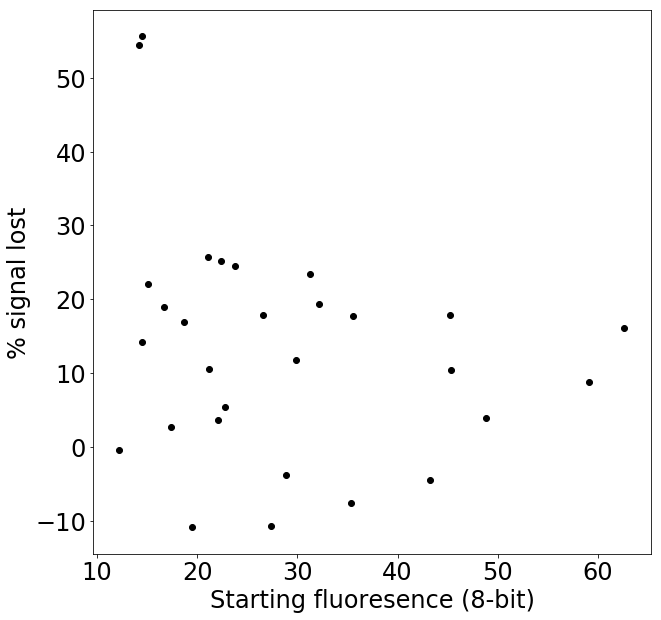

In [22]:
plt.figure(figsize=(10,10))
for fly in bleaching_decay:
    plt.scatter(starting_fluors[fly], bleaching_decay[fly],color='k')
plt.ylabel('% signal lost')
plt.xlabel('Starting fluoresence (8-bit)')

In [16]:
bleaching_decay

{'fly_1,func_0': 8.82388088932812,
 'fly_10,func_0': -7.48676232263498,
 'fly_11,func_0': 25.222126526713634,
 'fly_13,func_0': 22.097781013726305,
 'fly_15,func_0': 19.361769162919597,
 'fly_17,func_0': 25.768348413715074,
 'fly_19,func_0': 10.647402746506009,
 'fly_2,func_0': 16.14985388901774,
 'fly_21,func_0': -10.589905158272918,
 'fly_22,func_0': 3.730620517463611,
 'fly_24,func_0': -4.385796689373383,
 'fly_25,func_0': 17.873866364461353,
 'fly_26,func_0': 2.743116572877252,
 'fly_3,func_0': 17.765133517637548,
 'fly_4,func_0': 24.48916616607136,
 'fly_43,func_2': 11.784312802023697,
 'fly_44,func_0': -0.37799348711709013,
 'fly_45,func_0': -10.743473375282985,
 'fly_47,func_0': 54.40195283186946,
 'fly_48,func_0': 14.208205884612262,
 'fly_5,func_0': 3.990942637848561,
 'fly_51,func_0': 55.687440713314565,
 'fly_52,func_0': 16.898387236630914,
 'fly_53,func_0': 18.95874331714289,
 'fly_54,func_0': 5.489221720892536,
 'fly_68,func_0': 17.852419920905216,
 'fly_7,func_0': 10.4029

In [17]:
starting_fluors

{'fly_1,func_0': 59.10121644637837,
 'fly_10,func_0': 35.31024805967345,
 'fly_11,func_0': 22.373430929974905,
 'fly_13,func_0': 15.054012925274717,
 'fly_15,func_0': 32.176028742042824,
 'fly_17,func_0': 21.117011265978196,
 'fly_19,func_0': 21.170272899821292,
 'fly_2,func_0': 62.54574503030166,
 'fly_21,func_0': 27.324461484603884,
 'fly_22,func_0': 22.033274198554714,
 'fly_24,func_0': 43.21402080371178,
 'fly_25,func_0': 45.233103981749785,
 'fly_26,func_0': 17.423600562610225,
 'fly_3,func_0': 35.56296085267925,
 'fly_4,func_0': 23.771209976590576,
 'fly_43,func_2': 29.883277143870423,
 'fly_44,func_0': 12.205465054092404,
 'fly_45,func_0': 19.485321508147766,
 'fly_47,func_0': 14.179095478804165,
 'fly_48,func_0': 14.438414742392247,
 'fly_5,func_0': 48.83874787817565,
 'fly_51,func_0': 14.522174063441641,
 'fly_52,func_0': 18.72173570753092,
 'fly_53,func_0': 16.638222170431405,
 'fly_54,func_0': 22.741352724176185,
 'fly_68,func_0': 26.55778044542407,
 'fly_7,func_0': 45.34164

In [248]:
slopes = {}
for expt in bleaching_data:
    slopes[expt] = bleaching_data[expt]['bleaching_slope']
    print(expt, bleaching_data[expt]['bleaching_slope'])

fly_69,func_0 0.004774698520484813
fly_68,func_0 -0.001119794178407644
fly_54,func_0 -0.0002659398236266892
fly_53,func_0 -0.0006720071830932784
fly_52,func_0 -0.0006167008241726526
fly_51,func_0 -0.0017504405116169099
fly_49,func_0 -0.0036904817912008663
fly_48,func_0 -0.000449286852637264
fly_47,func_0 -0.0016013523661850967
fly_46,func_0 -0.0038445397170399705
fly_46,func_1 -0.0011183215628489296
fly_45,func_0 0.00046769652958717866
fly_44,func_0 8.769539035575942e-06
fly_43,func_0 -0.0036531626462011106
fly_43,func_1 -0.0066563725955019045
fly_43,func_2 -0.0006733338549971642
fly_42,func_0 -0.0003903206997603644
fly_42,func_1 -0.004088206579371744
fly_41,func_0 5.1377945800114225e-05
fly_40,func_0 -0.00015574862626760149
fly_39,func_0 -5.240519144987553e-06
fly_39,func_1 -0.00013282205935779605
fly_38,func_0 -4.998864780321228e-05
fly_38,func_1 1.6764183108139712e-05
fly_37,func_0 -3.6803729057885244e-06
fly_37,func_1 8.870348118695166e-05
fly_37,func_2 -0.00026185919883078937
fly_

In [250]:
slopes

{'fly_1,func_0': -0.0013018052407985402,
 'fly_10,func_0': 0.000641805638683871,
 'fly_11,func_0': -0.0012793160451433881,
 'fly_12,func_0': -0.0035087236118569575,
 'fly_13,func_0': -0.0006576913647885231,
 'fly_14,func_0': -0.002673044522657549,
 'fly_15,func_0': -0.0012737378643583894,
 'fly_16,func_0': 0.002097853781513479,
 'fly_17,func_0': -0.0013867276104325952,
 'fly_18,func_0': -0.002591649285792273,
 'fly_19,func_0': -0.0004949677180555646,
 'fly_2,func_0': -0.002210781198816139,
 'fly_20,func_0': -0.00031000725552724525,
 'fly_21,func_0': 0.0006621604279732771,
 'fly_22,func_0': -0.0001939542390524155,
 'fly_23,func_0': 0.007470050319953781,
 'fly_24,func_0': 0.00043479739800152074,
 'fly_25,func_0': -0.0019585556020082257,
 'fly_26,func_0': -0.0001103304150015589,
 'fly_27,func_0': 0.0011417141978106423,
 'fly_28,func_0': -0.0004036231252684596,
 'fly_29,func_0': -0.0030535731349385243,
 'fly_29,func_1': 0.0013209558532619433,
 'fly_3,func_0': -0.0016067704828043458,
 'fly_

In [239]:
-0.00033404827345047053 * 5000

-1.6702413672523526

In [ ]:
# fly 51 goes from 14 to 7 avg signal

In [241]:
good_expts

{'fly_1,func_0': 0.993469314867399,
 'fly_10,func_0': 0.9545865202806444,
 'fly_11,func_0': 1.071383572009747,
 'fly_13,func_0': 1.0874989194578653,
 'fly_15,func_0': 1.116754998752219,
 'fly_17,func_0': 1.0594065130869004,
 'fly_19,func_0': 1.1500974570824567,
 'fly_2,func_0': 1.0234734470846838,
 'fly_21,func_0': 1.0289775155361802,
 'fly_22,func_0': 1.0107055187231067,
 'fly_24,func_0': 1.0160113351373623,
 'fly_25,func_0': 0.9612431286628854,
 'fly_26,func_0': 0.982454257871639,
 'fly_3,func_0': 0.9623143769298849,
 'fly_4,func_0': 1.0216599063350589,
 'fly_43,func_2': 1.1524978925066283,
 'fly_44,func_0': 1.0036169775366448,
 'fly_45,func_0': 1.1045903426714014,
 'fly_47,func_0': 1.1188912860066185,
 'fly_48,func_0': 1.1179741509919872,
 'fly_5,func_0': 1.0555904719088451,
 'fly_51,func_0': 1.1415948792042412,
 'fly_52,func_0': 1.0093442203573864,
 'fly_53,func_0': 1.00036847260645,
 'fly_54,func_0': 1.1019506258851333,
 'fly_6,func_0': 1.0390449639760804,
 'fly_68,func_0': 1.1151

In [233]:
signal_decrease

{'fly_1,func_0': -0.1943736305101227,
 'fly_10,func_0': 0.163256160141845,
 'fly_11,func_0': -0.6053065770589736,
 'fly_13,func_0': -0.6644624547658284,
 'fly_15,func_0': -0.5644243899226333,
 'fly_17,func_0': -0.5767180830477162,
 'fly_19,func_0': -0.28357617838454713,
 'fly_2,func_0': -0.41352939063054495,
 'fly_21,func_0': 0.2610784266997904,
 'fly_22,func_0': -0.08851846081399908,
 'fly_24,func_0': 0.10721714965406945,
 'fly_25,func_0': -0.4091565181399725,
 'fly_26,func_0': -0.06602163676505875,
 'fly_3,func_0': -0.37578975319852975,
 'fly_4,func_0': -0.7203278086019549,
 'fly_43,func_2': -0.38349133836175,
 'fly_44,func_0': 0.011406364488262648,
 'fly_45,func_0': 0.2902328523101068,
 'fly_47,func_0': -1.4842681590079454,
 'fly_48,func_0': -0.36588228551707247,
 'fly_5,func_0': -0.10430559535368523,
 'fly_51,func_0': -1.5433030233411738,
 'fly_52,func_0': -0.48939674186727866,
 'fly_53,func_0': -0.5035047507646434,
 'fly_54,func_0': -0.1515790145710551,
 'fly_6,func_0': -0.2886790

In [257]:
starting_fluors

{'fly_1,func_0': 59.10121644637837,
 'fly_10,func_0': 35.31024805967345,
 'fly_11,func_0': 22.373430929974905,
 'fly_13,func_0': 15.054012925274717,
 'fly_15,func_0': 32.176028742042824,
 'fly_17,func_0': 21.117011265978196,
 'fly_19,func_0': 21.170272899821292,
 'fly_2,func_0': 62.54574503030166,
 'fly_21,func_0': 27.324461484603884,
 'fly_22,func_0': 22.033274198554714,
 'fly_24,func_0': 43.21402080371178,
 'fly_25,func_0': 45.233103981749785,
 'fly_26,func_0': 17.423600562610225,
 'fly_3,func_0': 35.56296085267925,
 'fly_4,func_0': 23.771209976590576,
 'fly_43,func_2': 29.883277143870423,
 'fly_44,func_0': 12.205465054092404,
 'fly_45,func_0': 19.485321508147766,
 'fly_47,func_0': 14.179095478804165,
 'fly_48,func_0': 14.438414742392247,
 'fly_5,func_0': 48.83874787817565,
 'fly_51,func_0': 14.522174063441641,
 'fly_52,func_0': 18.72173570753092,
 'fly_53,func_0': 16.638222170431405,
 'fly_54,func_0': 22.741352724176185,
 'fly_6,func_0': 64.60881480529561,
 'fly_68,func_0': 26.55778

In [228]:
ending_fluors

{'fly_1,func_0': 54.33970533459098,
 'fly_10,func_0': 37.03846708586548,
 'fly_11,func_0': 17.264661783938,
 'fly_13,func_0': 11.8365799234193,
 'fly_15,func_0': 26.692330936575765,
 'fly_17,func_0': 13.027601086571076,
 'fly_19,func_0': 20.10037811480828,
 'fly_2,func_0': 54.071667942014116,
 'fly_21,func_0': 28.94943129271098,
 'fly_22,func_0': 21.01981871872142,
 'fly_24,func_0': 42.402336662610644,
 'fly_25,func_0': 37.12090565148715,
 'fly_26,func_0': 15.770151869844602,
 'fly_3,func_0': 29.59499848118377,
 'fly_4,func_0': 19.0306086853552,
 'fly_43,func_2': 27.5216096871416,
 'fly_44,func_0': 11.835790488749673,
 'fly_45,func_0': 20.042203495848465,
 'fly_47,func_0': 6.836317945195689,
 'fly_48,func_0': 11.725459451227126,
 'fly_5,func_0': 49.71071437645436,
 'fly_51,func_0': 7.845786036811168,
 'fly_52,func_0': 15.646631955382379,
 'fly_53,func_0': 13.52306341860057,
 'fly_54,func_0': 21.769862730136364,
 'fly_6,func_0': 61.81456430359374,
 'fly_68,func_0': 20.88723580865328,
 '

In [224]:
signal_decrease

{'fly_1,func_0': -0.1943736305101227,
 'fly_10,func_0': 0.163256160141845,
 'fly_11,func_0': -0.6053065770589736,
 'fly_13,func_0': -0.6644624547658284,
 'fly_15,func_0': -0.5644243899226333,
 'fly_17,func_0': -0.5767180830477162,
 'fly_19,func_0': -0.28357617838454713,
 'fly_2,func_0': -0.41352939063054495,
 'fly_21,func_0': 0.2610784266997904,
 'fly_22,func_0': -0.08851846081399908,
 'fly_24,func_0': 0.10721714965406945,
 'fly_25,func_0': -0.4091565181399725,
 'fly_26,func_0': -0.06602163676505875,
 'fly_3,func_0': -0.37578975319852975,
 'fly_4,func_0': -0.7203278086019549,
 'fly_43,func_2': -0.38349133836175,
 'fly_44,func_0': 0.011406364488262648,
 'fly_45,func_0': 0.2902328523101068,
 'fly_47,func_0': -1.4842681590079454,
 'fly_48,func_0': -0.36588228551707247,
 'fly_5,func_0': -0.10430559535368523,
 'fly_51,func_0': -1.5433030233411738,
 'fly_52,func_0': -0.48939674186727866,
 'fly_53,func_0': -0.5035047507646434,
 'fly_54,func_0': -0.1515790145710551,
 'fly_6,func_0': -0.2886790

In [252]:
start_f_list = []
slope_list = []
percent_change_list = []
for fly in starting_fluors:
    slope_list.append(slopes[fly])
    start_f_list.append(starting_fluors[fly])
    percent_change = starting_fluors[fly] + slopes[fly] * 

In [255]:
len(start_f_list)

30

In [256]:
len(slope_list)

30

Text(0.5, 1.0, 'Bubble detection')

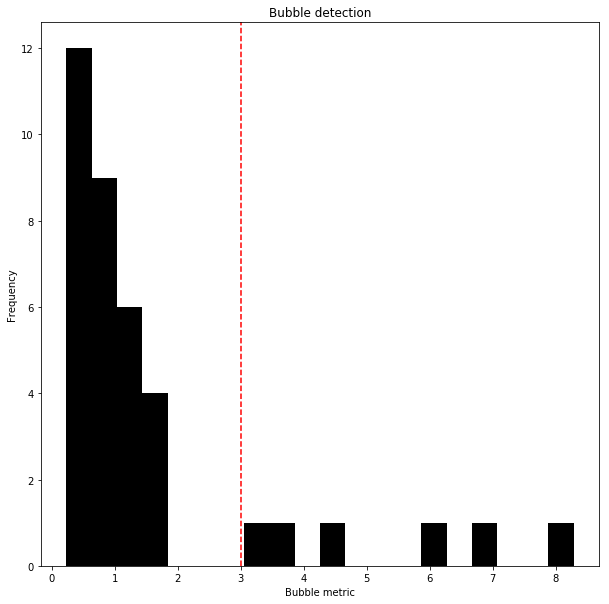

In [169]:
plt.figure(figsize=(10,10))
plt.hist(bubble_values,bins=20,color='k')
plt.axvline(3,linestyle='--',color='r')
plt.xlabel('Bubble metric')
plt.ylabel('Frequency')
plt.title('Bubble detection')

In [494]:
i = 1
laser_maxs = []
slopes = []
laser_mins = []
laser_mean = []
decay = []
dates = []
for fly in good_expts:
    try:
        laser_maxs.append(metadata[fly]['laser_power_max'])
        laser_mins.append(metadata[fly]['laser_power_min'])
        laser_mean.append((metadata[fly]['laser_power_max']+metadata[fly]['laser_power_min'])/2)
        dates.append(metadata[fly]['date'])
        decay.append(bleaching_decay[fly])
        slopes.append(good_expts[fly])
        print('{}: {} --- {} --- {}'.format(i, fly, metadata[fly]['laser_power_max'],good_expts[fly]))
        i+=1
    except:
        print(fly)

1: fly_68,func_0 --- 228 --- 0.0387234952160993
2: fly_54,func_0 --- 350 --- 0.040649332260210086
3: fly_53,func_0 --- 300 --- -0.01771717550979488
4: fly_52,func_0 --- 250 --- -0.00672765284677511
5: fly_51,func_0 --- 250 --- 0.05727395653949134
6: fly_48,func_0 --- 150 --- 0.10126800683669389
7: fly_47,func_0 --- 200 --- 0.09747377543336073
8: fly_45,func_0 --- 200 --- 0.01675649794073784
9: fly_44,func_0 --- 200 --- -0.02792255189454613
10: fly_43,func_2 --- 300 --- 0.02900628229973547
11: fly_26,func_0 --- 300 --- -0.017604738186995636
12: fly_25,func_0 --- 300 --- -0.0369929550949657
13: fly_24,func_0 --- 300 --- 0.006461473414198016
14: fly_22,func_0 --- 300 --- 0.002906174440587055
15: fly_21,func_0 --- 300 --- 0.013295002128349257
16: fly_19,func_0 --- 300 --- 0.0925192574148234
17: fly_17,func_0 --- 300 --- 0.03191077472105957
18: fly_15,func_0 --- 300 --- 0.04093192554362377
19: fly_13,func_0 --- 300 --- 0.016279986551079505
20: fly_11,func_0 --- 300 --- 0.09399627360470861
2

In [491]:
laser_mins

[228,
 250,
 200,
 201,
 200,
 150,
 151,
 170,
 141,
 202,
 140,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 201,
 200,
 171,
 150,
 160,
 200,
 160,
 200,
 281,
 201,
 200]

In [493]:
np.subtract(laser_maxs,laser_mins)

array([  0, 100, 100,  49,  50,   0,  49,  30,  59,  98, 160, 100, 100,
       100, 100, 100, 100, 100,  99, 100, 129, 150, 140,  50, 190, 120,
         0,  75,  50])

In [450]:
for fly in good_expts:
    print(fly)

fly_68,func_0
fly_54,func_0
fly_53,func_0
fly_52,func_0
fly_51,func_0
fly_48,func_0
fly_47,func_0
fly_45,func_0
fly_44,func_0
fly_43,func_2
fly_26,func_0
fly_25,func_0
fly_24,func_0
fly_22,func_0
fly_21,func_0
fly_19,func_0
fly_17,func_0
fly_15,func_0
fly_13,func_0
fly_11,func_0
fly_10,func_0
fly_9,func_0
fly_8,func_0
fly_7,func_0
fly_5,func_0
fly_4,func_0
fly_3,func_0
fly_2,func_0
fly_1,func_0


In [423]:
len(good_expts)

29

In [211]:
# slope is change per unit
signal_decrease = np.add(starting_fluors_, np.multiply(slopes, 1800))

In [214]:
np.multiply(slopes,1800)

array([-0.19165254, -0.05812574, -0.19307809, -0.17171816, -0.60128689,
       -0.14423743, -0.55463622,  0.11671562,  0.00390258, -0.13198555,
       -0.02743281, -0.17841127,  0.04427412, -0.03759633,  0.10753802,
       -0.11208545, -0.26454958, -0.2077211 , -0.23646351, -0.2470079 ,
        0.07134282,  0.03728375, -0.23680871, -0.1043159 , -0.08951289,
       -0.03968507, -0.24385745, -0.1720299 , -0.16291375, -0.08733713])

In [21]:
plt.rcParams.update({'font.size': 24})

In [ ]:
numpy.polyfit(numpy.log(x), y, 1)
array([ 8.46295607,  6.61867463])
# y ≈ 8.46 log(x) + 6.62

Text(0.5, 0, 'Pockels')

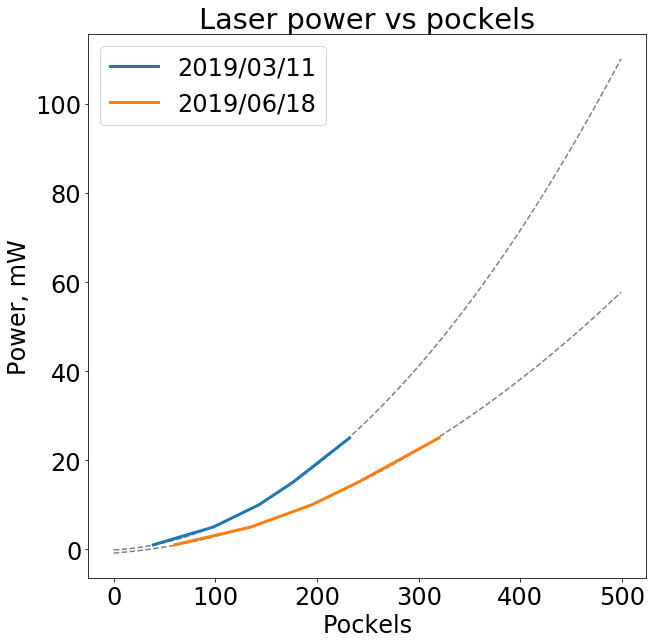

In [495]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 24})

powers = [1,5,10,15,20,25]
pockels_previous = [39,98,143,176,204,232]
pockels_current = [60,135,195,240,280,320]

fit_previous = np.polyfit(pockels_previous,powers,2)
xs = np.arange(500)
plt.plot(np.poly1d(fit_previous)(xs),linestyle='--',color='grey')

fit_current = np.polyfit(pockels_current,powers,2)
xs = np.arange(500)
plt.plot(np.poly1d(fit_current)(xs),linestyle='--',color='grey')

plt.plot(pockels_previous,powers,label='2019/03/11',linewidth=3)
plt.plot(pockels_current,powers,label='2019/06/18',linewidth=3)
plt.legend()
plt.title('Laser power vs pockels')
plt.ylabel('Power, mW')
plt.xlabel('Pockels')

In [497]:
power_true = []
pre_vs_post = []
gcamp = []
for i in range(len(dates)):
    if i < 10:
        power_true.append(np.poly1d(fit_current)(laser_mean[i]))
        pre_vs_post.append('r')
    else:
        pre_vs_post.append('k')
        power_true.append(np.poly1d(fit_previous)(laser_mean[i]))
    if i < 5:
        gcamp.append(9)
    else:
        gcamp.append(2)

Text(25, 53, 'big=6m')

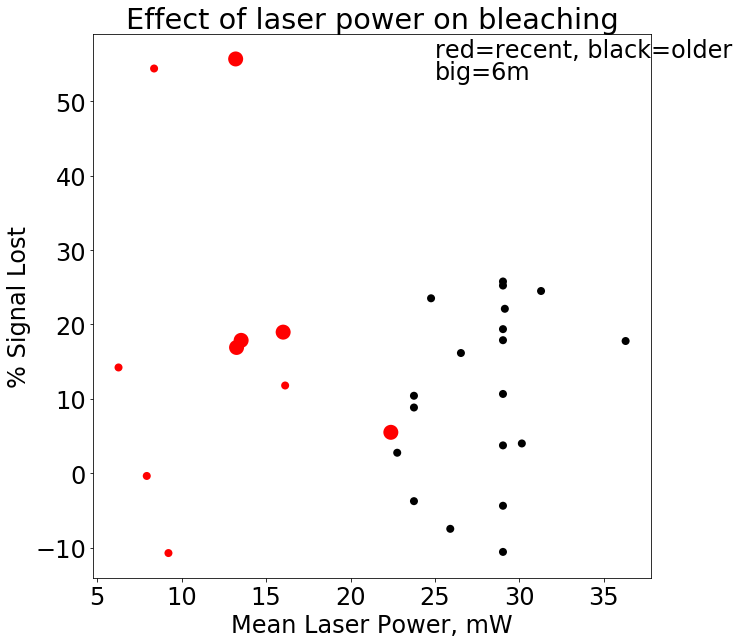

In [498]:
plt.figure(figsize=(10,10))
plt.scatter(power_true, decay, color=pre_vs_post, linewidths=gcamp)
plt.ylabel('% Signal Lost')
plt.xlabel('Mean Laser Power, mW')
plt.title('Effect of laser power on bleaching')
plt.text(25,56,'red=recent, black=older')
plt.text(25,53,'big=6m')
#plt.ylim(-.0002,.0002)

In [132]:
good_expts

{'fly_1,func_0': -4.852062668749943e-05,
 'fly_10,func_0': 3.963490170960063e-05,
 'fly_11,func_0': -0.0001372266100791144,
 'fly_13,func_0': -0.0001313686150189459,
 'fly_15,func_0': -0.00011540061131110884,
 'fly_17,func_0': -0.00014697198854427018,
 'fly_19,func_0': -6.226969222322072e-05,
 'fly_2,func_0': -9.050763638225979e-05,
 'fly_21,func_0': 5.974334707089026e-05,
 'fly_22,func_0': -2.0886847761679822e-05,
 'fly_24,func_0': 2.459673082222286e-05,
 'fly_25,func_0': -9.91173735804197e-05,
 'fly_26,func_0': -1.5240451700152064e-05,
 'fly_3,func_0': -9.557216510644195e-05,
 'fly_4,func_0': -0.0001354763604667961,
 'fly_43,func_2': -7.332530370205544e-05,
 'fly_44,func_0': 2.1680981730208418e-06,
 'fly_45,func_0': 6.484201347410787e-05,
 'fly_47,func_0': -0.00030813123500268746,
 'fly_48,func_0': -8.013190659594229e-05,
 'fly_5,func_0': -2.20472617530512e-05,
 'fly_51,func_0': -0.00033404827345047053,
 'fly_52,func_0': -9.539897502286134e-05,
 'fly_53,func_0': -0.000107265605190592

In [109]:
good_expts

[{'expt': 'fly_54,func_0', 'slope': -3.2292078093535384e-05},
 {'expt': 'fly_53,func_0', 'slope': -0.00010726560519059298},
 {'expt': 'fly_52,func_0', 'slope': -9.539897502286134e-05},
 {'expt': 'fly_51,func_0', 'slope': -0.00033404827345047053},
 {'expt': 'fly_48,func_0', 'slope': -8.013190659594229e-05},
 {'expt': 'fly_47,func_0', 'slope': -0.00030813123500268746},
 {'expt': 'fly_45,func_0', 'slope': 6.484201347410787e-05},
 {'expt': 'fly_44,func_0', 'slope': 2.1680981730208418e-06},
 {'expt': 'fly_43,func_2', 'slope': -7.332530370205544e-05},
 {'expt': 'fly_26,func_0', 'slope': -1.5240451700152064e-05},
 {'expt': 'fly_25,func_0', 'slope': -9.91173735804197e-05},
 {'expt': 'fly_24,func_0', 'slope': 2.459673082222286e-05},
 {'expt': 'fly_22,func_0', 'slope': -2.0886847761679822e-05},
 {'expt': 'fly_21,func_0', 'slope': 5.974334707089026e-05},
 {'expt': 'fly_19,func_0', 'slope': -6.226969222322072e-05},
 {'expt': 'fly_17,func_0', 'slope': -0.00014697198854427018},
 {'expt': 'fly_15,fun

In [64]:
bleaching_data[good_expts[0]]['bleaching_slope']

-0.0002659398236266892

In [83]:
bleaching_data[good_expts[0]].keys()

dict_keys(['percent_signal_lost', 'bleaching_slope', 'threshold', 'percent_above_thresh', 'intensity_histogram_over_time', 'bleaching'])

In [72]:
good_expts

['fly_54,func_0',
 'fly_53,func_0',
 'fly_52,func_0',
 'fly_51,func_0',
 'fly_48,func_0',
 'fly_47,func_0',
 'fly_45,func_0',
 'fly_44,func_0',
 'fly_43,func_2',
 'fly_26,func_0',
 'fly_25,func_0',
 'fly_24,func_0',
 'fly_22,func_0',
 'fly_21,func_0',
 'fly_19,func_0',
 'fly_17,func_0',
 'fly_15,func_0',
 'fly_13,func_0',
 'fly_11,func_0',
 'fly_10,func_0',
 'fly_9,func_0',
 'fly_8,func_0',
 'fly_7,func_0',
 'fly_6,func_0',
 'fly_5,func_0',
 'fly_4,func_0',
 'fly_3,func_0',
 'fly_2,func_0',
 'fly_1,func_0']

Text(0.5, 1.0, 'Mean Signal over Expt')

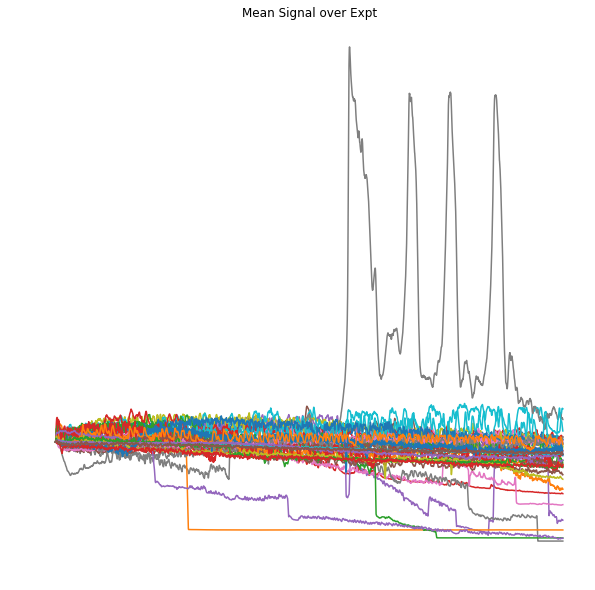

In [39]:
plt.figure(figsize=(10,10))
step = .25
for i,expt in enumerate(bleaching_data):
    try:
        #if len(bleaching_data[expt]['bleaching']) >
        fly_num = int(expt.split('_')[1].split(',')[0])
        if fly_num in good_flies:
            smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['bleaching'],sigma=4,axis=-1,truncate=1)
            num_frames = len(bleaching_data[expt]['bleaching'])
            imaging_rate = 1800/num_frames
            xs = np.arange(0,1800,imaging_rate)
            plt.plot(xs, (smoothed/smoothed[0]))
            #plt.text(-240,1+step*i,expt)
            #plt.text(-50,1+step*i,'{:0.0f}'.format(bleaching_data[expt]['percent_signal_lost']))
            #print(len((bleaching_data[expt]['percent_above_thresh'])))
        else:
            pass
    except:
        continue
plt.axis('off')
plt.title('Mean Signal over Expt')

Text(0.5, 1.0, 'Mean Signal over Expt, exclude bubble trials')

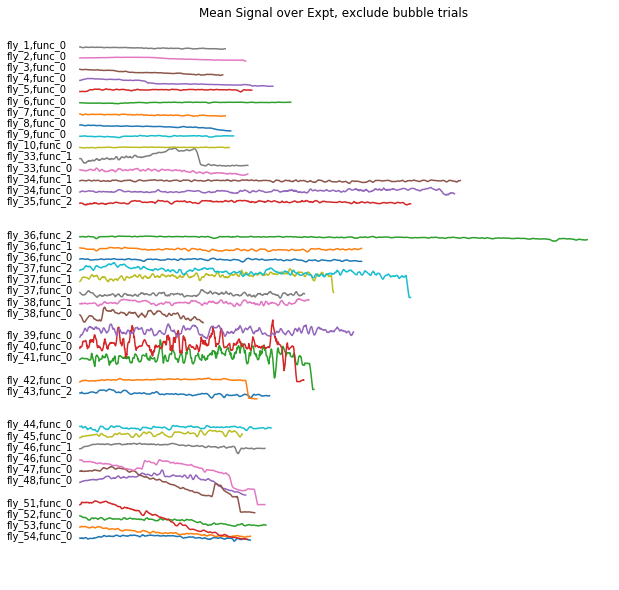

In [91]:
plt.figure(figsize=(10,10))
step = .25
for i,expt in enumerate(bleaching_data):
    #Remove these:
    if expt in ['fly_49,func_0',
                'fly_43,func_0',
                'fly_43,func_1',
                'fly_42,func_1',
                'fly_39,func_1',
                'fly_35,func_0',
                'fly_35,func_1']:
        continue
    smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['percent_above_thresh'],sigma=4,axis=-1,truncate=1)
    plt.plot((smoothed[:]/smoothed[0])+step*i)
    plt.text(-200,1+step*i,expt)
    #print(len((bleaching_data[expt]['percent_above_thresh'])))
plt.axis('off')
plt.title('Mean Signal over Expt, exclude bubble trials')

In [ ]:
plt.figure(figsize=(10,10))
for i,expt in enumerate(bleaching_data):
    smoothed = scipy.ndimage.gaussian_filter1d(bleaching_data[expt]['percent_above_thresh'],sigma=4,axis=-1,truncate=1)
    plt.plot(smoothed/smoothed[0])
    #print(len((bleaching_data[expt]['percent_above_thresh'])))

# Fictrac Quality Analysis